In [1]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

%matplotlib inline

import time

import numpy as np

import autoencoders

In [2]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [3]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.0005         # learning rate
N_TEST_IMG = 5
SHOW_LOSS = True
MODEL = 'AutoEncoder'

In [4]:
# Mnist digits dataset (download if necessary)
train_data = torchvision.datasets.FashionMNIST(
    root='./Datasets/fashion-mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),                        
    download=False,
)

In [5]:
n_loss_per_step = np.ceil(len(train_data)/BATCH_SIZE)-1

In [6]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on: cuda


In [8]:
# autoencoder = autoencoders.IncrementalAutoEncoder().to(device)
used_autoencoder = getattr(autoencoders, MODEL)
autoencoder = used_autoencoder().to(device)

print("Autoencoder in Cuda:", next(autoencoder.parameters()).is_cuda)
autoencoder.train()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss().to(device)

Autoencoder in Cuda: True


In [9]:
# original data (first row) for viewing
view_data = train_data.data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor).to(device)

Epoch:  9 | Average train loss: 0.0167


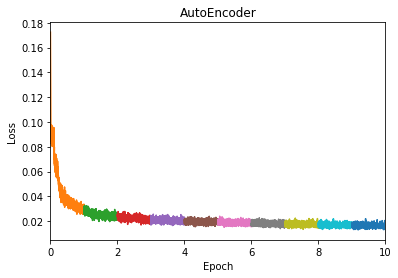

Done training!
CPU times: user 1min 18s, sys: 646 ms, total: 1min 19s
Wall time: 1min 29s


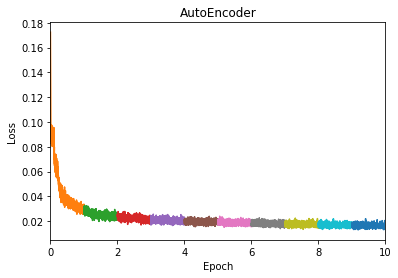

In [10]:
%%time

loss_list = []

pl.plot([],[])
pl.xlim(0, EPOCH)
pl.title(MODEL)
pl.xlabel("Epoch")
pl.ylabel("Loss")

for epoch in range(EPOCH):
    loss_list = []
    for step, (x, _) in enumerate(train_loader):
        batch = x.view(-1, 28*28).to(device)

        encoded, decoded = autoencoder(batch)
#         print(encoded[0])

        loss = loss_func(decoded, batch)   # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        loss_list.append(loss.item())

        if step % 500 == 0 and (epoch % 5 == 0 or epoch == EPOCH-1) and not SHOW_LOSS:        
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)

            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(N_TEST_IMG, 2))

            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                a[0][i].set_xticks(())
                a[0][i].set_yticks(())

            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(())
                a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)

    if SHOW_LOSS:
        position_list = []
        for i in range(len(loss_list)):
            position_list.append(i/n_loss_per_step + epoch)
        pl.plot(position_list, loss_list)
        display.clear_output(wait=True)
        print('Epoch: ', epoch, '| Average train loss: %.4f' % np.mean(loss_list))
        display.display(pl.gcf())
        time.sleep(1.0)
        
torch.save(autoencoder.state_dict(), "./Trained Models/" + MODEL + ".pt")
torch.cuda.empty_cache()

print("Done training!")

array([], dtype=float64)